In [169]:
%reset -f
%load_ext autoreload
%autoreload 2

import Odin as backend

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
# validation test for scalar convection + diffusion
# this validation test follows "H K Versteeg and W Malalasekera, An Introduction to Computational Fluid Dynamics
# THE FINITE VOLUME METHOD, Second Edition, 2007" examples 5.1

# the temperature along the x-axis should develop as:
def yFunc(x, case):
    if case == 1:
        return (2.7183-np.exp(x))/1.7183
    else:
        return 1+(1-np.exp(25*x))/(7.2e10)

case = 3   # 1,2,3

# geometric parameters
LenX = 1
LenY = 0.3
resolution = 20 if case == 3 else 5

#velocity in x direction: [ m/s ]
velX = 0.1 if case == 1 else 2.5

# thermal conductivity [ W / (m K) ]
k = 0.1#0.5/resolution

# const temperature at left/right boundaries [K]
T_l = 1
T_r = 0

In [171]:
geom = backend.createGeometry( 'rectangle', [LenX, LenY] )
mesh = backend.createMesh( geom, res=resolution )

mesh.getStats()

# example: incompressible flow but with temp-dep density, i.e. BoussinesqFlow
# mulitphase stokes flow
myFlowModels = {
    #'flowField'     :   backend.FlowModels.IncompressibleFlow(),
    'temperature'   :   backend.FlowModels.ScalarConvectionDiffusion(scalarFieldName='T', velocityFieldName='U', diffusionCoefficientName='k', sourceFieldName='R')
    }
myFlowModels['temperature']._properties['diffusionCoefficient'] = k
myFlowModels['temperature'].showContinuumProperties()

sim1 = backend.Simulation(myFlowModels, mesh, geom )
#print(type(sim1._variableFields['U']).__name__) # i can use this to remove the member variable _type

import Fields       # I should have better ways to generate new fields
sim1._variableFields['U'] = Fields.newField('vectorField', mesh, geom)

120
ScalarConvectionDiffusion:
	 {'diffusionCoefficient': 0.1, 'sourceFieldName': 'R', 'scalarFieldName': 'T', 'velocityFieldName': 'U'}


In [172]:
myFields = sim1.getFields()

# defining the velocity field:
# I name the field 'U' because that name was given to the flow model above
U = myFields['U']
U.setInitialValue([velX, 0])

# changing boundary conditions
T = myFields['T']
T.setBoundaryCondition('top', 'zeroGradient')
T.setBoundaryCondition('bottom', 'zeroGradient')
T.setBoundaryCondition('left', T_l)
T.setBoundaryCondition('right', T_r)

# setting conductivity and heat source:
sim1.showfields()
sim1.compile()
T.solve()

variable fields :
	 T 	 variableCellField 	 {'left': 1, 'right': 0, 'top': 'zeroGradient', 'bottom': 'zeroGradient'}
	 U 	 variableFaceField 	 {'left': None, 'right': None, 'top': None, 'bottom': None}
parameter fields :
	 U 	 parameterFaceField
	 R 	 scalar
	 k 	 scalar




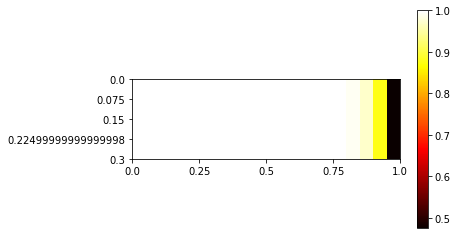

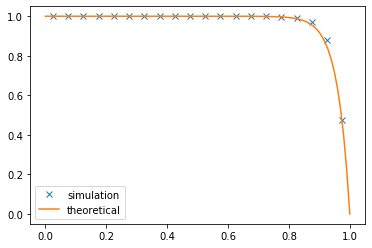

[1.         1.         1.         1.         1.         1.
 1.         0.99999999 0.99999995 0.99999978 0.99999903 0.99999579
 0.99998174 0.99992089 0.99965718 0.99851446 0.99356265 0.97210482
 0.87912088 0.47619048]


In [173]:
# post-processing:
import numpy as np
import matplotlib.pyplot as plt

sim1.display(T)

nbcellsX = sim1._mesh._cells_x
cellSpacing = sim1._mesh._uniformSpacing
L = geom._lenX

xSim = np.linspace(0+0.5*cellSpacing,LenX-0.5*cellSpacing,nbcellsX)
ySim = T._raw[0,:]

xTheo = np.linspace(0,LenX, 100)
yTheor = np.array([yFunc(x, case) for x in xTheo])

ax = plt.gca()
ax.plot(xSim, ySim, 'x', label='simulation')
ax.plot(xTheo, yTheor, label='theoretical')

plt.legend()
plt.show()

print(ySim)

